In [1]:
from scipy.stats import qmc
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from multiprocessing import Pool

In [63]:
T = 1.
S0 = 100
K = 100
SIGMA_I = 0.25
SIGMA_A = 0.35
R = 0.05
N = 7
D_T = T/(2**N)

In [154]:
def cal_BSM_call_delta(s, k, r, sigma, T):
    if T <= 1e-6:
        return 0.
    d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def cal_BSM_call_option(s, k, r, sigma, T):
    if T <= 1e-6:
        return 0.
    d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return s * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)

def simulate_asset_path(s0, k, r, sigma, dt, n):
    rand_vec = np.random.normal(size=2**n)
    path1 = np.exp(rand_vec * np.sqrt(dt) * sigma + (r - 0.5 * sigma ** 2) * dt)
    path1[0] = 1.
    path1 = np.cumprod(path1)* s0
    path2 = np.exp(-rand_vec * np.sqrt(dt) * sigma + (r - 0.5 * sigma ** 2) * dt)
    path2[0] = 1.
    path2 = np.cumprod(path2)* s0
    return [path1, path2]

def get_BSM_delta_path(path, k, r, sigma_hedge):
    f = lambda s, t: cal_BSM_call_delta(s, k, r, sigma_hedge, t)
    vectorizer = np.vectorize(f)
    return vectorizer(path, np.arange(len(path)-1,-1,-1) * D_T)

def dynamic_delta_hedging(path, BSM_delta_path, k, r, sigma, T, dt):
    
    cash_balance = np.zeros(len(path))
    option_val_path = np.zeros(len(path))
    portfolio_balance = np.zeros(len(path))
    V0 = cal_BSM_call_option(path[0], k, r, sigma, T)
    option_val_path[0] = V0
    portfolio_balance[0] = V0 - BSM_delta_path[0] * path[0]
    cash_balance[0] = BSM_delta_path[0] * path[0] - V0#positive when we receive money (short selling)
    
    for i in range(1, len(path)):
        
        cash_balance[i] = (BSM_delta_path[i] - BSM_delta_path[i-1]) * path[i] + cash_balance[i-1] * np.exp(r * dt)
        option_val_path[i] = cal_BSM_call_option(path[i], k, r, sigma, T - dt * i)
        portfolio_balance[i] = option_val_path[i] - BSM_delta_path[i] * path[i]

    option_val_path[-1] = max(path[-1] - k, 0)
    portfolio_balance[-1] = option_val_path[-1] - BSM_delta_path[-1] * path[-1]
    p_and_l_path = portfolio_balance + cash_balance
    return cash_balance, portfolio_balance, p_and_l_path

def simple_delta_hedging_simulation(s0, k, r, sigma_asset, sigma_hedge, sigma_implied, dt, T, n):
    path1, path2 = simulate_asset_path(s0, k, r, sigma_asset, dt, n)
    delta_path1 = get_BSM_delta_path(path1, k, r, sigma_hedge)
    cash_balance1, portfolio_balance1, p_and_l_path1 = dynamic_delta_hedging(path1, 
                                                                             delta_path1,
                                                                          k, 
                                                                          r, 
                                                                          sigma_implied, 
                                                                          T, 
                                                                          dt)
    delta_path2 = get_BSM_delta_path(path2, k, r, sigma_asset)
    cash_balance2, portfolio_balance2, p_and_l_path2 = dynamic_delta_hedging(path2,
                                                                             delta_path2,
                                                                          k, 
                                                                          r, 
                                                                          sigma_implied, 
                                                                          T, 
                                                                          dt)
    return np.stack([p_and_l_path2, p_and_l_path1], axis=0)

In [155]:
path1, path2 = simulate_asset_path(s0=S0, k=K, r=R, sigma=SIGMA_A, dt=D_T, n=N)
path1

array([100.        , 104.03470865, 102.98812444, 105.19507114,
       104.121497  , 103.02633914,  95.61213061,  91.49236691,
        88.74955761,  85.10810562,  86.21840675,  83.05231552,
        80.10747223,  80.44248246,  81.62224819,  83.69865489,
        81.92396821,  85.15465779,  78.38279757,  77.76487939,
        77.58408226,  79.41594563,  78.89537927,  77.69254548,
        77.23646465,  76.46800425,  73.12589179,  73.19927291,
        70.81937838,  70.54900475,  68.58205227,  65.5638223 ,
        62.97727343,  62.62614328,  64.62866341,  62.7243319 ,
        64.93940359,  62.46400087,  64.43214717,  62.32034003,
        63.61983538,  65.82005225,  66.97581659,  67.49627596,
        66.21606828,  66.03142966,  69.03230398,  64.20891937,
        64.27635308,  63.69111601,  65.98447357,  63.12952418,
        66.36172533,  65.77362018,  65.80960078,  65.76901978,
        65.34916858,  66.98560202,  66.02939676,  64.84780818,
        64.09663262,  64.34540101,  61.59740579,  62.95

In [156]:
get_BSM_delta_path(path1, k=K, r=R, sigma_hedge=SIGMA_I)

array([6.26928007e-001, 6.85068352e-001, 6.70157361e-001, 7.00454510e-001,
       6.85591674e-001, 6.69831063e-001, 5.52265717e-001, 4.79008305e-001,
       4.27883509e-001, 3.59528449e-001, 3.78401718e-001, 3.18862382e-001,
       2.65017075e-001, 2.69044945e-001, 2.88032417e-001, 3.23862509e-001,
       2.89871178e-001, 3.47483790e-001, 2.24867773e-001, 2.12848475e-001,
       2.08037191e-001, 2.36597701e-001, 2.25861618e-001, 2.04076634e-001,
       1.94829103e-001, 1.80859623e-001, 1.31208583e-001, 1.30375166e-001,
       9.96574821e-002, 9.50259617e-002, 7.35279772e-002, 4.76230143e-002,
       3.09550144e-002, 2.83313183e-002, 3.82472343e-002, 2.71079598e-002,
       3.80293978e-002, 2.42890677e-002, 3.30639287e-002, 2.21208061e-002,
       2.70350917e-002, 3.79800214e-002, 4.43117381e-002, 4.67007351e-002,
       3.70437572e-002, 3.48344529e-002, 5.42539952e-002, 2.35928656e-002,
       2.30193564e-002, 1.97995072e-002, 2.92410963e-002, 1.62837660e-002,
       2.91144595e-002, 2

In [157]:
simple_delta_hedging_simulation(s0=S0, k=K, r=R, sigma_asset=SIGMA_A, sigma_hedge=SIGMA_I, sigma_implied=SIGMA_I, dt=D_T, T=T, n=N)

array([[ 0.00000000e+00, -3.27185837e-02, -5.47909364e-02,
         6.11085035e-03,  2.22023885e-01,  1.41504286e-01,
         9.09129315e-02,  5.91022338e-02,  2.79695738e-02,
         3.40609745e-03, -2.05755966e-02, -3.56381237e-02,
        -1.75852260e-02, -5.66674862e-02, -9.58717146e-02,
        -8.25319456e-02, -1.16166837e-01, -8.44538567e-02,
        -1.25260053e-01, -1.30918234e-01, -1.41346845e-01,
        -1.36681232e-01, -1.70162660e-01, -2.11814517e-01,
        -2.23203140e-01, -2.66199217e-01, -2.13842031e-01,
        -2.35910190e-01, -2.16079365e-01, -2.69301010e-01,
        -2.95593711e-01, -3.34069644e-01, -3.97281954e-01,
        -4.47749950e-01, -4.96360338e-01, -5.38684032e-01,
        -5.52872216e-01, -5.80650308e-01, -5.99517526e-01,
        -5.72243685e-01, -5.34997536e-01, -4.57374568e-01,
        -4.28426571e-01, -5.07853919e-01, -3.88455102e-01,
        -4.42262691e-01, -2.11118845e-01, -2.49881589e-01,
        -3.89498055e-01, -5.32754194e-01, -4.46899855e-0

# Hedging with implied volatility

In [181]:
n_trial = 100000
out = []
with tqdm(total=n_trial) as pbar:
    for i in range(n_trial):
        out.append(simple_delta_hedging_simulation(s0=S0, k=K, r=R, sigma_asset=SIGMA_A, sigma_hedge=SIGMA_I, sigma_implied=SIGMA_I, dt=D_T, T=T, n=N))
        pbar.update(1)
out = np.concatenate(out)
out.shape

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:01:46<00:00, 26.98it/s]


(200000, 128)

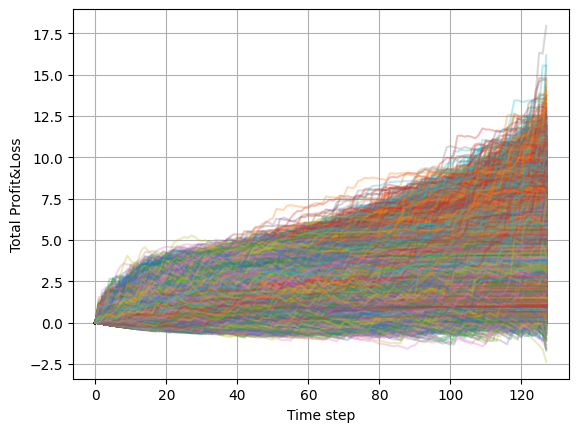

In [182]:
plt.plot(out.T, alpha=0.3)
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Total Profit&Loss")
plt.show()

In [183]:
print("P&L mean:", out[:,-1].mean(), "P&L SE:", out[:,-1].std()/np.sqrt(n_trial), "95% confidence internval: [", np.round(out[:,-1].mean() - 1.96*out[:,-1].std()/np.sqrt(n_trial), 3), ",", np.round(out[:,-1].mean() + 1.96*out[:,-1].std()/np.sqrt(n_trial), 3), "]")

P&L mean: 3.906935030748293 P&L SE: 0.005166011532965802 95% confidence internval: [ 3.897 , 3.917 ]


# Hedging with actual volatility

In [184]:
n_trial = 100000
out2 = []
with tqdm(total=n_trial) as pbar:
    for i in range(n_trial):
        out2.append(simple_delta_hedging_simulation(s0=S0, k=K, r=R, sigma_asset=SIGMA_A, sigma_hedge=SIGMA_A, sigma_implied=SIGMA_I, dt=D_T, T=T, n=N))
        pbar.update(1)
out2 = np.concatenate(out2)
out2.shape

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [54:19<00:00, 30.68it/s]


(200000, 128)

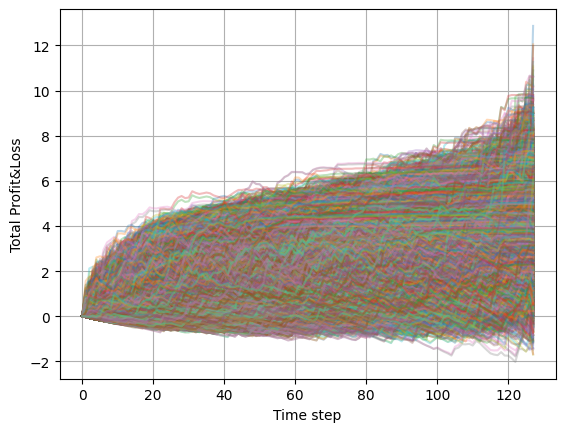

In [185]:
plt.plot(out2.T, alpha=0.3)
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Total Profit&Loss")
plt.show()

In [186]:
print("P&L mean:", out2[:,-1].mean(), "P&L SE:", out2[:,-1].std()/np.sqrt(n_trial), "95% confidence internval: [", np.round(out2[:,-1].mean() - 1.96*out2[:,-1].std()/np.sqrt(n_trial), 3), ",", np.round(out2[:,-1].mean() + 1.96*out2[:,-1].std()/np.sqrt(n_trial), 3), "]")

P&L mean: 3.9107380286635856 P&L SE: 0.003403924814755885 95% confidence internval: [ 3.904 , 3.917 ]


In [187]:
V_I = cal_BSM_call_option(S0, K, R, SIGMA_I, T)
V_A = cal_BSM_call_option(S0, K, R, SIGMA_A, T)
V_A - V_I

3.7924299512071613